# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 5
# Logistic Regression and PCA 

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately): Walter Thornton and Dwayne Kennemore

Enrollment Status (109A, 121A, 209A, or E109A): E109A

Import libraries:

In [13]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import spline
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import math
%matplotlib inline

#--------  visualize_prob
# A function to visualize the probabilities predicted by a Logistic Regression model
# Input: 
#      model (Logistic regression model)
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data: 0 or 1)
#      ax (an axis object to generate the plot)

def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for
    # import numpy as np
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[np.where(y==1)]
    #ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bx', label ='ALL')
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'rx', label = 'AML')
    
    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])




## Cancer Classification from Gene Expressions

In this homework assignment, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `dataset_hw5.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following parts, we will use logistic regression to build a classification model for this data set. We will also use principal components analysis (PCA) to visualize the data and to reduce its dimensions. 



## Part (a): Data Exploration

1. First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

2. Take a peak at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

3. Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

4. A convenient tool to visualize the gene expression data is a heat map. Arrange the rows of the training set so that the 'AML' rows are grouped together and the 'ALL' rows are together. Generate a heat map of the data with expression values from the following genes: 
`D49818_at`, `M23161_at`, `hum_alu_at`, `AFFX-PheX-5_at`, `M15990_at`. By observing the heat map, comment on which of these genes are useful in discriminating between the two classes.

5. We can also visualize this data set in two dimensions using PCA. Find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the AML and ALL points in different colors. How well do the top two principal components discriminate between the two classes?



In [14]:
'''
The problem with fitting a classification model to a data set that is short is that when P > n the regression model
is not specified. The number of predictors has to be reduced by some technique (such as PCA analysis).

We made the heat map as asked, but we could not discern a meaningful relationship by looking at the gene expression levels
visually. Perhaps if we used a different color scheme it would be more plain, but we decided we're going to just have to rely
on the numbers.

We found the top two principal components explained around 28% of the variance.
'''

"\nThe problem with fitting a classification model to a data set that is short is that when P > n the regression model\nis not specified. The number of predictors has to be reduced by some technique (such as PCA analysis).\n\nWe made the heat map as asked, but we could not discern a meaningful relationship by looking at the gene expression levels\nvisually. Perhaps if we used a different color scheme it would be more plain, but we decided we're going to just have to rely\non the numbers.\n\nWe found the top two principal components explained around 28% of the variance.\n"

In [15]:
# Import our data

np.random.seed(9001)
df = pd.read_csv('dataset_hw5.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

# Scale the data
x = data_train.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_train = pd.DataFrame(x_scaled, columns = data_train.columns)

x = data_test.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_test = pd.DataFrame(x_scaled, columns = data_test.columns)

# For use later preserving column names for part D
df_ = pd.DataFrame(data_train, columns = data_test.columns)
df_ = df_.drop('Cancer_type', axis=1)



C:\Users\wlt42\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


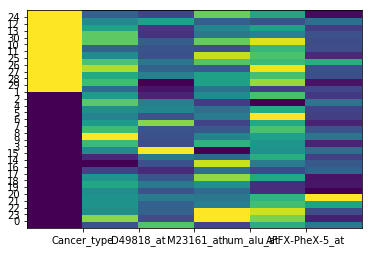

In [16]:
# Make heatmap
Cols = ['Cancer_type', 'D49818_at', 'M23161_at', 'hum_alu_at', 'AFFX-PheX-5_at', 'M15990_at']
heatmap_df = data_train[Cols].copy()
heatmap_df = heatmap_df.sort_values(by="Cancer_type")
heatmap_df

plt.pcolor(heatmap_df)
plt.yticks(np.arange(1, len(heatmap_df.index), 1), heatmap_df.index)
plt.xticks(np.arange(1, len(heatmap_df.columns), 1), heatmap_df.columns)

plt.show()

In [17]:
pca_input = data_train.drop('Cancer_type', axis=1)
X_train_for_pca = np.array(pca_input)

pca = PCA(n_components=2)
transformed_data = pca.fit_transform(X_train_for_pca)


dfpca = pd.DataFrame({"target" : data_train['Cancer_type']})
for i in range(pca.explained_variance_ratio_.shape[0]):
    dfpca["pc%i" % (i+1)] = transformed_data[:,i]


print('Percent Explained variance:', 100*pca.explained_variance_ratio_)
print('\n')

print(dfpca.head())


Percent Explained variance: [ 17.20614726  10.73253617]


   target        pc1        pc2
0     0.0   7.667012  -0.181414
1     0.0  -8.705269  -3.125841
2     0.0  21.341975   8.695756
3     0.0  11.527633  23.669014
4     0.0  -7.842507   7.473386


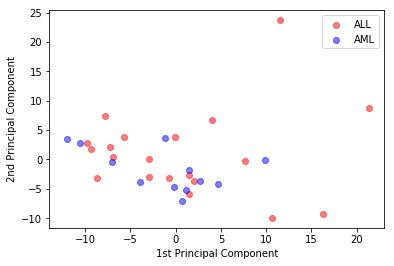

In [18]:
colors = ['red', 'blue']

for label, color in zip(dfpca['target'].unique(), colors):
    mask = dfpca['target']==label
    plt.scatter(dfpca[mask]['pc1'], dfpca[mask]['pc2'], c=color, label=label, alpha=0.5)
plt.legend(['ALL', 'AML'])
plt.xlabel ("1st Principal Component")
plt.ylabel("2nd Principal Component")

In [19]:
y_train = data_train['Cancer_type'].values
X_train = data_train[['D29963_at']].values
y_train = y_train.reshape(len(y_train), 1)

y_test = data_test['Cancer_type'].values
X_test = data_test[['D29963_at']].values
y_test = y_test.reshape(len(y_test), 1)


## Part (b): Linear Regression vs. Logistic Regression

Begin by analyzing the differences between using linear regression and logistic regression for classification. For this part, you shall work with a single gene predictor: `M23161_at`.

1. Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by regression model interpreted for a patient as an estimate of the probability that the patient has the `ALL` type cancer (class 1). Is there a problem with this interpretation?

2. The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into the `ALL` type (class 1), and the others into the `AML` type (class 0). Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

3. Next, fit a simple logistic regression model to the training set. How does the training and test calssification accuracy of this model compare with the linear regression model?  Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order not to regularize (use 'C=100000').

4. Plot the quantitative output from linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot.
Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.



In [20]:
'''
An interpretation that the regression model score is a probability that the patient has ALL type cancer would
not make sense because linear regression is not suitable for classification type application. Plus, some values for
D29963_at could well result in a negative probability.

The logistic regression is clearly better than the linear regression for predicting the presence of cancer. Classification
accuracy was 83% in the test case with five false negative for the OLS regression. While this result is better than a coin
flip, the logistic regression provided 92.7% accuracy.
'''

'\nAn interpretation that the regression model score is a probability that the patient has ALL type cancer would\nnot make sense because linear regression is not suitable for classification type application. Plus, some values for\nD29963_at could well result in a negative probability.\n\nThe logistic regression is clearly better than the linear regression for predicting the presence of cancer. Classification\naccuracy was 83% in the test case with five false negative for the OLS regression. While this result is better than a coin\nflip, the logistic regression provided 92.7% accuracy.\n'

In [21]:
def leppard(source_data, prediction_data):
    false_negative = 0
    false_positive = 0
    correct_assessment = 0
    for result in range(0, len(prediction_data)):
        if int(prediction_data[result]) == 1 and int(source_data[result]) == 0:
            false_positive += 1
        if int(prediction_data[result]) == 0 and int(source_data[result]) == 1:
            false_negative += 1
        if (int(prediction_data[result]) == 1 and int(source_data[result]) == 1) or (int(prediction_data[result]) == 0 and int(source_data[result]) == 0):
            correct_assessment += 1
    print ()
    print ("False Positives: ", false_positive)
    print ("False Negatives: ", false_negative)
    print ("Correct Assessment: ", correct_assessment)

    print ("Classification Accuracy: ", 1 - (false_positive + false_negative) / len(source_data))

# Linear regression on D29963_at
lm = LinearRegression(fit_intercept=True)
lm.fit(X_train, y_train)
lm_y_pred_train = lm.predict(X_train)
print('The equation of the regression using single gene predictor D29963_at is: {} + {}x'.format(lm.intercept_, lm.coef_))

lm.fit(X_test, y_test)
lm_y_pred_test = lm.predict(X_test)


results = lm.intercept_ + lm.coef_ * X_train
results = np.round_(results, 0)
i_results = []
for result in range(0, len(results)):
    if results[result] < .5:
        i_results.append(0)
    else:
        i_results.append(1)

# Try on the train set
cancer_train = data_train['Cancer_type'].values
cancer_train = cancer_train.reshape(len(cancer_train), 1)
print('\n')
print('Training data:')
#print(cancer_train)
#print(i_results)
leppard(cancer_train, i_results)

# Now on the test set
results = lm.intercept_ + lm.coef_ * X_test
results = np.round_(results, 0)
j_results = []
for result in range(0, len(results)):
    if results[result] < .5:
        j_results.append(0)
    else:
        j_results.append(1)
        
cancer_test = data_test['Cancer_type'].values
cancer_test = cancer_test.reshape(len(cancer_test), 1)
print('\n')
print('Testing data:')
leppard(cancer_test, j_results)



The equation of the regression using single gene predictor D29963_at is: [ 0.13126285] + [[ 0.75087457]]x


Training data:

False Positives:  1
False Negatives:  8
Correct Assessment:  23
Classification Accuracy:  0.71875


Testing data:

False Positives:  2
False Negatives:  5
Correct Assessment:  34
Classification Accuracy:  0.8292682926829268


In [22]:
# Logistic regression on D29963_at
clf = LogisticRegression(C=100000)
clf.fit(X_train, y_train)

# The coefficients
print('Estimated beta1: \n', clf.coef_)
print('Estimated beta0: \n', clf.intercept_)

# Scoring
clf_y_pred_train = clf.predict(X_train)
clf_y_pred_test = clf.predict(X_test)
clf_y_pred_train = clf_y_pred_train.reshape(len(clf_y_pred_train), 1)


print('\n')
#print('Training data:')
#print(clf_y_pred_train)
#print(i_results)
#leppard(clf_y_pred_train, i_results)
#print('\n')
#print('Testing data:')
#leppard(clf_y_pred_test, j_results)

# Metrics
print('\n')
print('Test Set Confusion matrix:') 
print(confusion_matrix(y_test, clf.predict(X_test)))

train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print('The training classification accuracy is: ', train_score)
print('The testing classification accuracy is: ', test_score)

Estimated beta1: 
 [[ 3.55392665]]
Estimated beta0: 
 [-1.6981375]




Test Set Confusion matrix:
[[26  2]
 [ 5  8]]
The training classification accuracy is:  0.71875
The testing classification accuracy is:  0.829268292683


C:\Users\wlt42\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


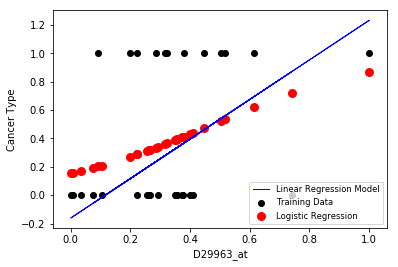

In [23]:
# Plot training data
plt.scatter(data_train[['D29963_at']], data_train['Cancer_type'],  color='black')

# plot logistic 
def model(x):
    return 1 / (1 + np.exp(-x))
loss = model(X_train * clf.coef_ + clf.intercept_).ravel()
plt.scatter(X_train, loss, color='red', linewidth=3)
X = np.sort(X_train)
#plt.plot(X, clf.predict(X), color='red',lw=1)
# plot linear
plt.plot(X_train, lm.predict(X_train), color='blue',lw=1)

# Labels and such
plt.xlabel ("D29963_at")
plt.ylabel("Cancer Type")

plt.legend(('Linear Regression Model', 'Training Data', 'Logistic Regression'),
           loc="best", fontsize='small')


# Alternate plot logistic 
#def model(x):
#    return 1 / (1 + np.exp(-x))
#loss = model(X_train * clf.coef_ + clf.intercept_).ravel()
#plt.scatter(X_train, loss, color='red', linewidth=2)



# Alternate plot training data
#plt.scatter(X_train.ravel(), y_train, color='black', zorder=20)


# Alternate plot linear
#ols = linear_model.LinearRegression()
#ols.fit(X_train, y_train)
#plt.plot(X_train, ols.coef_ * X_train + ols.intercept_, linewidth=1)
#plt.axhline(.5, color='.5')

plt.show()

## Part (c): Multiple Logistic Regression

1. Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in Part (b) with a single gene (on both the training and test sets)?  

2. "Use the `visualize_prob` from `HW5_functions.py` to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the `ALL` and `AML` classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line.  Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?"

The training accuracy of for the model with all predictors is 100%, compared to a training score of 71.8%. This makes since in that we expect more predictors to increase training accuracy. Perhaps due to the limited number of observation, the testing score of the model with one predictor was higher than its training score at 82.9%. The testing accuracy for the secon model clearly outperformed the first, with a testing accuracy of 92.7%

We had many problems implementing the visualization function. We can say that those points that fall close to the .5 line can of course be classified using a different probability threshold if it was determined that errors of one type were more costly than errors of another type.

In [29]:
y_train = data_train['Cancer_type'].values
y_train = y_train.reshape(len(y_train), 1)
y_test = data_test['Cancer_type'].values
y_test = y_test.reshape(len(y_test), 1)

df_train = data_train.drop('Cancer_type', axis=1)
df_test = data_test.drop('Cancer_type', axis=1)
X_train = np.array(df_train)
X_test = np.array(df_test)

In [30]:
# Create logistic regression object
logitm = LogisticRegression(C = 1000000)
logitm.fit (X_train, y_train)

# The coefficients
print("Logistic Regression - TRAIN")
print('Estimated betas: \n', logitm.coef_)
print('Estimated beta0: \n', logitm.intercept_)

print("Logistic Regression - TEST")
train_score_log = logitm.score(X_train, y_train)
test_score_log = logitm.score(X_test, y_test)
print('Training score of model', train_score_log)
print('Testing score of model', test_score_log)


Logistic Regression - TRAIN
Estimated betas: 
 [[ 0.02556793 -0.0393443   0.01185487 ...,  0.00151029  0.09575496
   0.00958508]]
Estimated beta0: 
 [-0.00831347]
Logistic Regression - TEST
Training score of model 1.0
Testing score of model 0.926829268293


C:\Users\wlt42\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


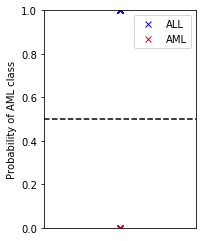

In [27]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
# starter code
y_train_viz = data_train["Cancer_type"]
y_test_viz = data_test["Cancer_type"]

# Note: We tried various ways to get this function to work, but in the end it would not
# and we are not sure why.
visualize_prob(logitm, X_train, y_train_viz, ax1)

## Part (d): Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a *significance level of 95%*? 

Hint: To answer this question, use *bootstrapping* with 100 boostrap samples/iterations.  



We found 956 predictors whose coefficients are significantly different than 0 at the level of 95%. 
A dataframe below lists these predictors along with the results of the bootstrapping

In [5]:
# FROM PREVIOUS HOMEWORK
# randomly sample our data

def sample(x, y, k):
    n = x.shape[0] # No. of training points
    
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n), k)
    
    # Get predictors and reponses with the indices
    x_subset = x[subset_ind, :]
    y_subset = y[subset_ind]
   
    return (x_subset, y_subset)

In [31]:
# Bootstrap 100 random samples from population

coeff_dict = {}
tdict = {}

for i in range(0, 100):
    
    sample_X, sample_y = sample(X_train, y_train, 22)
    
    # Create logistic regression object
    logit = LogisticRegression(C = 1000000)
    logit.fit(sample_X, sample_y)

    # The coefficients
    row = logit.coef_[0] 
    tdict = {i : row}
    coeff_dict.update(tdict)
   
 

C:\Users\wlt42\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [32]:
# Create a dataframe for our hundred resamples

df = pd.DataFrame(coeff_dict)
df = df.T
df.columns = df_.columns
df = df.T

In [33]:
# compute statistics from bootstrapped samples

df['Mean'] = df.mean(axis=1)
df['STD'] = df.std(axis=1)
df['CI Lower'] = df['Mean'] - 1.96* df['STD']
df['CI Upper'] = df['Mean'] + 1.96* df['STD']
df['Standard Error'] = (df['CI Upper'] - df['CI Lower'])/(2*1.96)
df['Variance'] = df['STD'] * df['STD']
df['t stat'] = df['Mean']/df['Standard Error']

In [34]:
df_significant = df[~((df['CI Upper']>0) & (df['CI Lower']<0))]
df_significant = df_significant[['Mean','STD','Standard Error','Variance','t stat','CI Lower','CI Upper']]

In [35]:
# Dataframe of all predictors significantly different from 0 at the level of 95% 

temp_df = df_significant.T
significant_pred = list(temp_df.columns)
print(temp_df.head())

                AFFX-BioB-3_st  AFFX-HUMISGF3A/M97935_MA_at  AFFX-M27830_5_at  \
Mean                 -0.020462                     0.024847         -0.027560   
STD                   0.009457                     0.010593          0.011174   
Standard Error        0.009457                     0.010593          0.011174   
Variance              0.000089                     0.000112          0.000125   
t stat               -2.163767                     2.345592         -2.466339   

                AFFX-M27830_M_at  AB000114_at  AB000449_at  AB000905_at  \
Mean                   -0.026957    -0.036298    -0.025948    -0.038268   
STD                     0.009387     0.017119     0.009702     0.015890   
Standard Error          0.009387     0.017119     0.009702     0.015890   
Variance                0.000088     0.000293     0.000094     0.000252   
t stat                 -2.871751    -2.120340    -2.674580    -2.408328   

                AB002559_at  AC000061_cds2_at  AC000064_cds1_a

In [36]:

X_train_significant = data_train[significant_pred].values
y_train_significant = data_train['Cancer_type'].values
X_test_significant = data_test[significant_pred].values
y_test_significant = data_test['Cancer_type'].values


In [37]:
# Create logistic regression object
logit_significant = LogisticRegression(C = 1000000)
logit_significant.fit(X_train_significant, y_train_significant)

# The coefficients
print('Estimated betas: \n', logit_significant.coef_)
print('Estimated beta0: \n', logit_significant.intercept_)

train_score_significant = logit_significant.score(X_train_significant, y_train_significant)
test_score_significant = logit_significant.score(X_test_significant, y_test_significant)
print('Training score of model', train_score_significant)
print('Testing score of model', test_score_significant)

Estimated betas: 
 [[ -7.61590382e-02   7.48193488e-02  -7.32091966e-02  -7.27898245e-02
   -1.07971652e-01  -7.35103765e-02  -1.13040374e-01   1.21231152e-01
   -1.28047529e-01   1.12081841e-01  -8.41125034e-02  -1.31390396e-01
   -6.52983650e-02  -5.50626296e-02  -1.31008026e-01  -1.20419402e-01
    3.45985110e-01   7.20597746e-02  -1.65158995e-01  -1.66011118e-01
    1.66516128e-01  -1.36924555e-02   1.39216155e-01   1.00409899e-01
    5.07245227e-02  -1.56813837e-01   5.69712170e-02  -7.71137726e-02
    2.67081183e-01   4.21511711e-02  -9.51858769e-02  -7.88464426e-02
    2.38926411e-01   1.04011324e-01  -1.54133078e-01  -5.61290155e-02
   -1.93947934e-01  -4.33288671e-02  -4.19758443e-02  -9.62206850e-02
   -3.69377509e-02  -2.05217634e-01  -2.94901142e-01   9.74104101e-02
    1.41671566e-01   3.00172975e-01  -9.29071179e-02   7.03819068e-02
   -1.08523360e-01  -4.41833008e-02  -2.40350975e-01  -4.67852640e-02
   -3.39258286e-02   1.04057712e-01  -1.02928715e-01  -1.48868195e-01
 

## Part (e): Dimensionality Reduction using PCA

A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the first set of principal components contributing to 90% of the variance in the predictors.

1. How do the classification accuracy values on both the training and tests sets compare with the models fitted in Parts (c) and (d)?  

2. Re-fit a logistic regression model using 5-fold cross-validation to choose the number of principal components, and comment on whether you get better test performance than the model fitted above (explain your observations). 

3. Use the code provided in Part (c) to visualize the probabilities predicted by the fitted models on both the training and test sets. How does the spread of probabilities in these plots compare to those for the models in Part (c) and (d)? 


In [ ]:
Our best model used 24 PCA components with a testing accuracy of almost 93%. 
This matches the accuracy of the above model with all predictors, but has the advantage of being a simpler model.

In [38]:
# Find the number of PCA components whose explained variance is > 90%
for i in range(0, len(X_train[1])):
    pca = PCA(n_components=i)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    if pca.explained_variance_ratio_.sum() > .9:
        components = i
        break

In [39]:
# Create logistic regression object
logit_pca = LogisticRegression(C = 1000000)
logit_pca.fit (X_train_pca, y_train)

# The coefficients
print('Estimated betas: \n', logitm.coef_)
print('Estimated beta0: \n', logitm.intercept_)

train_score = logitm.score(X_train, y_train)
test_score = logitm.score(X_test, y_test)
print('\n')
print('Training score of model', train_score)
print('Testing score of model', test_score)
print('\n')
print('Number of PCA components used', components)


Estimated betas: 
 [[ 0.02556793 -0.0393443   0.01185487 ...,  0.00151029  0.09575496
   0.00958508]]
Estimated beta0: 
 [-0.00831347]


Training score of model 1.0
Testing score of model 0.926829268293


Number of PCA components used 24


C:\Users\wlt42\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [40]:

y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(32, 7129) (32,)
(41, 7129) (41,)


In [41]:
clf_pipe = LogisticRegression()
pca_pipe = decomposition.PCA()
pca_pipe.fit(X_train[1])

pipe = Pipeline(steps=[('pca', pca_pipe), ('logistic', clf_pipe)])
#n_components = [32, 64, 128, 256, 512, 768, 1024, 1200]
n_components = list(np.arange(1, 1000, 1))
estimator = GridSearchCV(pipe, dict(pca__n_components=n_components, logistic__C=(1000000, 1000001)))
estimator.fit(X_train, y_train)
estimator.cv_results_.keys()
print('The best parameters of the model are:', estimator.best_params_)
#
#print('With a mean training score of:', estimator.mean_train_score )
print('With a mean testing score of:', estimator.best_score_)

results_df = pd.DataFrame(estimator.cv_results_)
#estimator.cv_results_()
# The coefficv_results_()cients
#print('Estimated betas: \n', estimated.coef_)
#print('Estimated beta0: \n', estimated.intercept_)

#train_score_pipe = estimated.score(X_train, y_train)
#test_score_pipe = estimated.score(X_test, y_test)
#print('\n')
#print('Training score of model', train_score_pipe)
#print('Testing score of model', test_score_pipe)
#print('\n')
#print('Number of PCA components used', n_components)
results_df

C:\Users\wlt42\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\wlt42\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:398: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


The best parameters of the model are: {'logistic__C': 1000000, 'pca__n_components': 18}
With a mean testing score of: 0.90625


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_logistic__C,param_pca__n_components,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.024974,0.000067,0.65625,0.608947,1000000,1,"{'logistic__C': 1000000, 'pca__n_components': 1}",1995,0.636364,0.619048,0.636364,0.571429,0.7,0.636364,0.003531,9.508329e-05,0.029496,0.027455
1,0.032082,0.001339,0.59375,0.720779,1000000,2,"{'logistic__C': 1000000, 'pca__n_components': 2}",1997,0.636364,0.809524,0.545455,0.761905,0.6,0.590909,0.000877,1.893236e-03,0.037924,0.093867
2,0.020402,0.001081,0.71875,0.920635,1000000,3,"{'logistic__C': 1000000, 'pca__n_components': 3}",1988,0.727273,0.952381,0.636364,0.809524,0.8,1.000000,0.003395,7.792827e-04,0.066492,0.080937
3,0.029016,0.001670,0.71875,0.968254,1000000,4,"{'logistic__C': 1000000, 'pca__n_components': 4}",1988,0.727273,0.904762,0.818182,1.000000,0.6,1.000000,0.004121,1.701032e-03,0.088489,0.044896
4,0.029183,0.000000,0.71875,0.968254,1000000,5,"{'logistic__C': 1000000, 'pca__n_components': 5}",1988,0.727273,0.904762,0.818182,1.000000,0.6,1.000000,0.008733,0.000000e+00,0.088489,0.044896
5,0.031928,0.003001,0.71875,1.000000,1000000,6,"{'logistic__C': 1000000, 'pca__n_components': 6}",1988,0.818182,1.000000,0.727273,1.000000,0.6,1.000000,0.001755,1.412819e-03,0.088489,0.000000
6,0.031936,0.000616,0.75000,1.000000,1000000,7,"{'logistic__C': 1000000, 'pca__n_components': 7}",1985,0.818182,1.000000,0.727273,1.000000,0.7,1.000000,0.001849,6.432164e-04,0.050565,0.000000
7,0.033771,0.001488,0.81250,1.000000,1000000,8,"{'logistic__C': 1000000, 'pca__n_components': 8}",1973,0.818182,1.000000,0.818182,1.000000,0.8,1.000000,0.002417,2.104870e-03,0.008427,0.000000
8,0.039174,0.003003,0.81250,1.000000,1000000,9,"{'logistic__C': 1000000, 'pca__n_components': 9}",1973,0.818182,1.000000,0.818182,1.000000,0.8,1.000000,0.002720,1.412877e-03,0.008427,0.000000
9,0.036612,0.001151,0.81250,1.000000,1000000,10,"{'logistic__C': 1000000, 'pca__n_components': 10}",1973,0.818182,1.000000,0.818182,1.000000,0.8,1.000000,0.000646,2.533883e-04,0.008427,0.000000


---
 

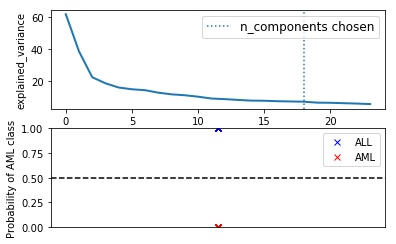

In [173]:
plt.clf()
fig = plt.figure()
ax2 = fig.add_subplot(121)
#plt.axes([.2, .2, .7, .7])
ax2 = plt.subplot(2, 1, 1)
ax2.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance')

ax2.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax2.legend(prop=dict(size=12))

ax1 = fig.add_subplot(122)
ax1 = plt.subplot(2, 1, 2)
y_train_viz = data_train["Cancer_type"]
visualize_prob(estimator.best_estimator_, X_train, y_train_viz, ax1)
plt.show()

# APCOMP209a - Homework Question

Suppose we want to conduct PCA on the model matrix $X \in \Re^{n×p}$, where the columns have been suitably set to zero mean. In this question, we consider the squared reconstruction error:

$$  \parallel XQ- XQ_m \parallel ^2 $$

for a suitable set of eigenvectors forming the matrix $Q_m$, as discussed below. Suppose that we conduct eigendecomposition of $X^T X$ and obtain eigenvalues $\lambda_1, \ldots , \lambda_p$ and principal components $Q$, i.e.

$$ X^T X = Q \Lambda Q ^T $$

(1) Suppose that the matrix norm is simply the squared dot product, namely

$$ \parallel A \parallel ^2 = A^T A $$

Then, express the reconstruction error as a sum of matrix products.

(2) Simplify your result from (1) based on properties of the matrices $Q$.

(3) Now let $Q_m$ be the matrix of the first $m < p$ eigenvectors, namely

$$ Q_m = (q_1, \ldots, q_m, 0, \ldots, 0) \in \Re^{p \times p} $$

Thus, $X Q_m$ is the PCA projection of the data into the space spanned by the first $m$ principal components. Express the products $Q^T_m Q$ and $Q^T Q_m$, again using properties of the eigenbasis $q_1, \ldots, q_p$.

(4) Use your results from (3) to finally fully simplify your expression from (2).

(5) Note that the result you obtain should still be a matrix, i.e. this does not define a proper norm on the space of matrices (since the value should be a scalar). Consequently, the true matrix norm is actually the trace of the
above result, namely

$$ \parallel A \parallel ^2  = {\rm trace} (A^T A) $$
Use your result from (4) and this new definition to find a simple expression
for the reconstruction error in terms of the eigenvalues.

(6) Interpret your result from (5). In light of your results, does our procedure for PCA (selecting the $m$ substantially larger eigenvalues) make sense? Why or why not?